In [9]:
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from skimage import io
import fs
import torchvision
from torchvision import transforms
import torch

from torch.utils.data import Dataset, DataLoader
import torchvision

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
cuda = torch.cuda.is_available()
import time
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
#rename all the training pictures#################### only for rename
test_path = 'C:/Users/zhaoh/Downloads/car recognition/croped_images/audi/'
i=0
#carlabel=[[0 for x in range(10000)] for x in range(2)] 
#print(carlabel)
for f in os.listdir(test_path):
    name=os.path.join(test_path+str(f))
    if "jpg." not in name:
        test_path =name
        #newname=os.path.join(test_path,'benz suv'+str(i)+'.jpg')
        #os.rename(name, newname)
        #test_image=newname
        filename = os.path.join(test_path, test_image)
    else:
        i=i+1
    #print(format(filename))
    
    img=io.imread(filename)
    #print(img.shape)
    #carlabel[1][i]=401
    #carlabel[0][i]=str(img)
    i=i+1
#print(carlabel)
'''
write_file=open('train_data.pkl','wb')  
pickle.dump(carlabel,write_file)  
write_file.close()'''
############################################################

In [14]:
from torch.utils.data import Dataset, DataLoader
class DrivingDataset(Dataset):
    def __init__(self,data_dir, input_w=224, input_h=224,is_train=True):
        """{0:"other",1:"drink",2:"phone",3:"smoke"}"""
        self.data_filenames = []
        self.data_ids = []
        self.is_train=is_train

        self.data_root=fs.open_fs(data_dir)
        for p in self.data_root.walk.files(filter=["*.jpg"]):
            filename=data_dir+p
            self.data_filenames.append(filename)
            if "dazhong" and "sedan" in filename:
                self.data_ids.append(1)
            elif "上汽大众" in filename:
                self.data_ids.append(2)
            elif "benz." and "sedan." in filename:
                self.data_ids.append(50)
            elif "benz."and "suv" in filename:
                self.data_ids.append(51)
            else:
                self.data_ids.append(0)

        # print(self.data_filenames)
        print(self.data_ids)
        print(len(self.data_ids))
        if is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                # transforms.ColorJitter(brightness=0.1, contrast=0.05, saturation=0.1, hue=0.02),
                # transforms.RandomCrop(448),
                transforms.RandomRotation(degrees=5, resample=Image.BILINEAR),
                transforms.RandomHorizontalFlip(),
                transforms.RandomGrayscale(p=0.1),
                transforms.ToTensor(),
                #transforms.Normalize(mean=(0.21501742 ,0.21501742, 0.21501742), std=(0.22761705 ,0.22761705, 0.22761705)),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                # transforms.RandomCrop(448),
                transforms.RandomGrayscale(p=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.21501742, 0.21501742, 0.21501742),std=(0.22761705, 0.22761705, 0.22761705)),

            ])

        self.input_w = input_w
        self.input_h = input_h

    def __getitem__(self, item):
        """Grey(i, j) = 0.299 × R(i, j) + 0.587 × G(i, j) + 0.114 × B(i, j)"""


        # while True:
        #     img_path = self.data_filenames[item]
        #     target = self.data_ids[item]
        #     # print(img_path)
        #
        #     image = cv2.imread(img_path)
        #     if image is None:
        #         os.remove(img_path)
        #         item+=1
        #     else:
        #         break


        img_path = self.data_filenames[item]
        #print(img_path)
        target = self.data_ids[item]

        image = io.imread(img_path)#发现cv2不支持路径中有中文，换成io.imread
        #img=image
        
        resize_image = self.resize_padding(image, self.input_w, self.input_h)
        transpose_image = resize_image[:, :, ::-1].copy()
        
        img = self.transform(transpose_image)
        #print(img.shape)
        target = np.array([target], dtype=np.long)
        target = torch.from_numpy(target)

        # img.save("./img/gray2.jpg",quality=95)

        # r = img[:, :, 0] * 0.299
        # g = img[:, :, 1] * 0.587
        # b = img[:, :, 2] * 0.114
        # img[:, :, 0]=img[:, :, 1]=img[:, :, 2]=r+g+b
        #
        # cv2.imwrite("./img/gray.jpg",img[:, :, ::-1].copy())


        return img,target

    def __len__(self):
        return len(self.data_filenames)
    
    def resize_padding(self, x, inputwidth, inputheight):
        scale = float(float(inputwidth) / float(inputheight))
        h, w, c = x.shape
        if float(float(w) / float(h)) >= scale:
            # padding h
            dif = np.abs(w / scale - h)
            pad1, pad2 = int(dif // 2), int(dif - dif // 2)
            pad = ((pad1, pad2), (0, 0), (0, 0))
            input_x = np.pad(x, pad, "constant", constant_values=0)
            input_img = cv2.resize(input_x, (inputwidth, inputheight))
        else:
            # padding w
            dif = np.abs(h * scale - w)
            pad1, pad2 = int(dif // 2), int(dif - dif // 2)
            pad = ((0, 0), (pad1, pad2), (0, 0))
            input_x = np.pad(x, pad, "constant", constant_values=0)
            input_img = cv2.resize(input_x, (inputwidth, inputheight))

        return input_img

In [15]:
#a new file system that can go through all sub-folders##################################only for test

#test_path = 'C:/Users/zhaoh/Downloads/car recognition/data/honda/sedan/'
test_path='C:/Users/zhaoh/Downloads/car recognition/croped_images/大众/'
i=0
#carlabel=[[0 for x in range(10000)] for x in range(2)] 
#print(carlabel)
data_root=fs.open_fs(test_path)
for p in data_root.walk.files(filter=["*.jpg"]):
    i=i+1

print(i)
##############################################


2603


In [16]:
train_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/car recognition/croped_images/大众/", is_train=True) 
#val_set = DrivingDataset(trn_val_tst=1, transform=torchvision.transforms.ToTensor()) 
#test_set = DrivingDataset(trn_val_tst=2, transform=torchvision.transforms.ToTensor()) 


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
batch_size = 100
#n_workers = multiprocessing.cpu_count()
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
#testloader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                          #shuffle=True, num_workers=0)
#valloader = torch.utils.data.DataLoader(val_set, batch_size=100,
                                          #shuffle=True, num_workers=0)

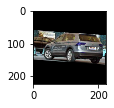

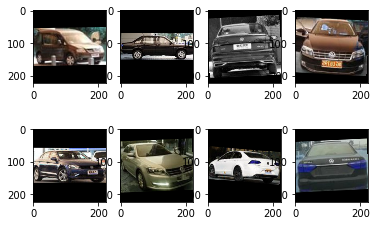

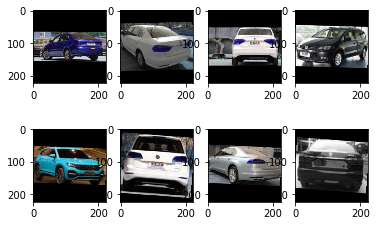

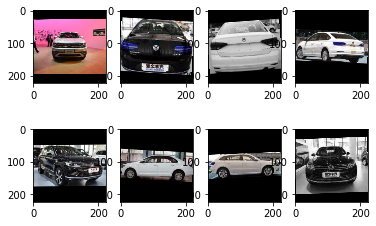

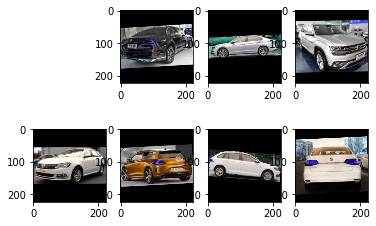

In [18]:
image_batch, labels = next(iter(trainloader))
for i in range(32): 
    img = np.moveaxis(image_batch[i].numpy(),0,2)
    plt.subplot(2,4,(i%8+1))
    plt.imshow(img)
    if i%8==0:
        plt.show()
    


In [23]:
#define the network below
####################################
#######################################
###########################################
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url 


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model





def resnet152(pretrained=True, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)





In [24]:
import torch.optim as optim
model = resnet152(pretrained=True)#torch.load('model2.pkl')
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
print(model)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

)


In [20]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.to(device).half()

    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    start_time = time.time()
    for label,[data, target] in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.to(device).half()
        target = target.long().to(device).half()

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()
        acc = (correct_predictions/total_predictions)*100.0
        loss.backward()
        optimizer.step()

    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time,' train accuracy',acc)
    return running_loss,acc

In [21]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device).half()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        #Predicted=[]
        for data, target in (test_loader):   
            data = data.to(device).half()
            target = target.long().to(device).half()

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            #Predicted.append(predicted)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [22]:
n_epochs = 200
Train_loss = []
Test_loss = []
Test_acc = []
Val_loss = []
Val_acc = []
Train_acc=[]
for i in range(n_epochs):
    
    train_loss,train_acc = train_epoch(model, trainloader, criterion, optimizer)
    #test_loss, test_acc = test_model(model, testloader, criterion)
    #val_loss, val_acc = test_model(model, valloader, criterion)
    Train_acc.append(train_acc)
    Train_loss.append(train_loss)
    #Val_acc.append(val_acc)
    #Val_loss.append(val_loss)
    #Test_loss.append(test_loss)
    #Test_acc.append(test_acc)
    print(i,'epoch='*20)
#test_loss, test_acc = test_model(model, testloader, criterion)

RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 6.00 GiB total capacity; 4.02 GiB already allocated; 128.63 MiB free; 176.70 MiB cached)